In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
from datetime import datetime
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
import geopandas as gpd
import shapely

## Load Xenium data into `InSituData` object

In [4]:
insitupy_project = Path("../demo_dataset/demo_insitupy_project")

In [5]:
xd = read_xenium(insitupy_project)

In [6]:
xd.load_cells()
xd.load_images()

Loading cells...
	No alternative cells found...
Loading images...


In [7]:
from skmisc.loess import loess

In [8]:
x = xd.cells.matrix.obs["dist_from_points"].values

In [9]:
x

array([2430.10811097, 2437.20976022, 2424.43241978, ..., 1302.58062876,
       1314.47557425, 1320.18842919])

In [10]:
gene = "ACTA2"
gene_id = xd.cells.matrix.var_names.get_loc(gene)
y = xd.cells.matrix.X[:, gene_id].toarray().T[0]

In [11]:
ls = loess(x, y)

In [12]:
ls.fit()

In [13]:
nsteps = 100
xmin = x.min()
xmax = x.max()
xs = x

stepsize = (xmax - xmin) / nsteps
#if stepsize is not None:
xs_pred = np.asarray(np.arange(xmin, xmax+stepsize, stepsize))
xs_pred = np.linspace(xmin, xmax, nsteps)
xs_pred = xs_pred[(xs_pred < xs.max()) & (xs_pred > xs.min())]

In [14]:
pred = ls.predict(xs_pred, stderror=False)

In [15]:
x

array([2430.10811097, 2437.20976022, 2424.43241978, ..., 1302.58062876,
       1314.47557425, 1320.18842919])

In [16]:
ls.inputs.x

array([2430.10811097, 2437.20976022, 2424.43241978, ..., 1302.58062876,
       1314.47557425, 1320.18842919])

## Kernel crashes with `stderr=False`

--> Implement bootstrapping version of it

In [18]:
type(ls)

_loess.loess

In [19]:
from skmisc.loess import loess

In [20]:
ls = loess(x, y)

In [21]:
ls.fit()

In [22]:
from scipy import stats

In [23]:
class lowess_confidence_intervals:
    '''
    Class to store confidence intervals of lowess prediction.
    '''
    def __init__(self, lower, upper):
        self.lower = lower
        self.upper = upper

class bootstrap_loess:
    '''
    Class to calculate standard error and confidence intervals of LOESS regression using bootstrapping.
    '''
    def __init__(self,
                 loess_object: loess,
                 ):
        self.x = loess_object.inputs.x
        self.y = loess_object.inputs.y

    def _single_bootstrap_loess(self, newdata, sample_frac=0.5):

        # subsample data
        samples = np.random.choice(len(x), int(len(x)*sample_frac), replace=True)
        y_s = y[samples]
        x_s = x[samples]

        # fit on subsampled data and predict for new data using LOESS
        ls = loess(x_s, y_s)
        pred = ls.predict(newdata)
        return pred.values

    def calc_loess_stderror_by_bootstrap(self, newdata, sample_frac=0.5, K=100, **kwargs):
        '''
        Interesting input on topic from:
            - https://acclab.github.io/bootstrap-confidence-intervals.html
            - https://stackoverflow.com/questions/28242593/correct-way-to-obtain-confidence-interval-with-scipy
        '''
        # calculate confidence interval using bootstrapping approach
        self.bootstrap_result = np.stack([self._single_bootstrap_loess(newdata, sample_frac=sample_frac, **kwargs) for k in range(K)]).T

        # calc mean and stderr of smooths
        self.stderr = np.nanstd(self.bootstrap_result, axis=1, ddof=0) # OR std

    def confidence(self, alpha=0.05, percentile_method=False):
        if percentile_method:
            # use 2.5 and 97.5% percentiles to calculate the 95% confidence interval
            # This approach is mentioned here: https://acclab.github.io/bootstrap-confidence-intervals.html
            # However I am not sure if it is also valid for low numbers of bootstrapping cycles.
            lower = np.nanpercentile(self.bootstrap_result, 2.5, axis=1) #2.5 percent
            upper = np.nanpercentile(self.bootstrap_result, 97.5, axis=1) # 97.5 percent
        else:
            # calculate 95% CI use formula for confidence interval
            self.smooths_mean = np.nanmean(self.bootstrap_result, axis=1)
            lower, upper = stats.norm.interval(1-alpha, loc=self.smooths_mean, scale=self.stderr)

        return lowess_confidence_intervals(lower, upper)


In [24]:
bl = bootstrap_loess(ls)

In [25]:
bl.calc_loess_stderror_by_bootstrap(newdata=xs_pred)

In [26]:
conf = bl.confidence()

In [27]:
from insitupy.plotting.expression_along_axis import expr_along_obs_val

In [28]:
data = expr_along_obs_val(adata=xd.cells.matrix,
                   keys="ACTA2",
                   x_category="dist_from_points", groupby=None, return_data=True,
                   stderr=True, nsteps=10, loess_bootstrap=True
                   )

In [29]:
data

x    y_pred   std  conf_lower  conf_upper
key                                                              
ACTA2 None 0   494.611700  1.861635  True    1.816492    1.905278
           1   985.097950  2.118863  True    2.076706    2.165005
           2  1475.584199  2.112905  True    2.071185    2.156295
           3  1966.070448  1.885631  True    1.842536    1.926765
           4  2456.556698  1.728198  True    1.687819    1.768570
           5  2947.042947  1.641977  True    1.601183    1.686782
           6  3437.529196  1.515681  True    1.470702    1.570679
           7  3928.015445  1.363965  True    1.278352    1.468688

In [30]:
data = expr_along_obs_val(adata=xd.cells.matrix,
                   keys="ACTA2",
                   x_category="dist_from_points", groupby=None, return_data=True,
                   stderr=True, nsteps=100, loess_bootstrap=True
                   )

In [31]:
data

x    y_pred   std  conf_lower  conf_upper
key                                                               
ACTA2 None 0     48.715110  1.574211  True    1.463674    1.691228
           1     93.304769  1.605815  True    1.507303    1.710632
           2    137.894428  1.636566  True    1.549229    1.730026
           3    182.484087  1.666546  True    1.589467    1.749560
           4    227.073746  1.695836  True    1.628019    1.769397
...                    ...       ...   ...         ...         ...
           93  4195.553400  1.269274  True    1.114164    1.408210
           94  4240.143059  1.252620  True    1.088460    1.399901
           95  4284.732718  1.235709  True    1.062148    1.391661
           96  4329.322377  1.218539  True    1.035226    1.383484
           97  4373.912036  1.201108  True    1.007696    1.375364

[98 rows x 5 columns]

In [35]:
y

array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)

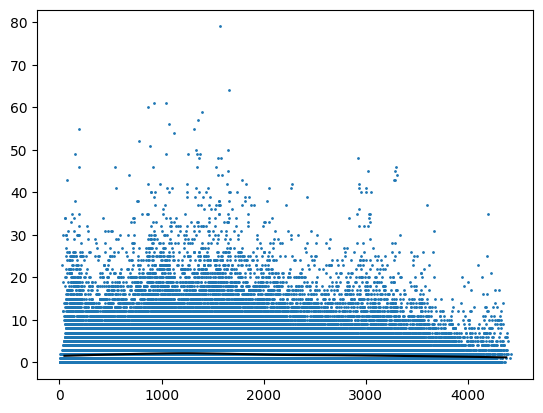

In [43]:
plt.scatter(x, y, s=1)
plt.plot(data["x"], data["y_pred"], c='k')
plt.show()

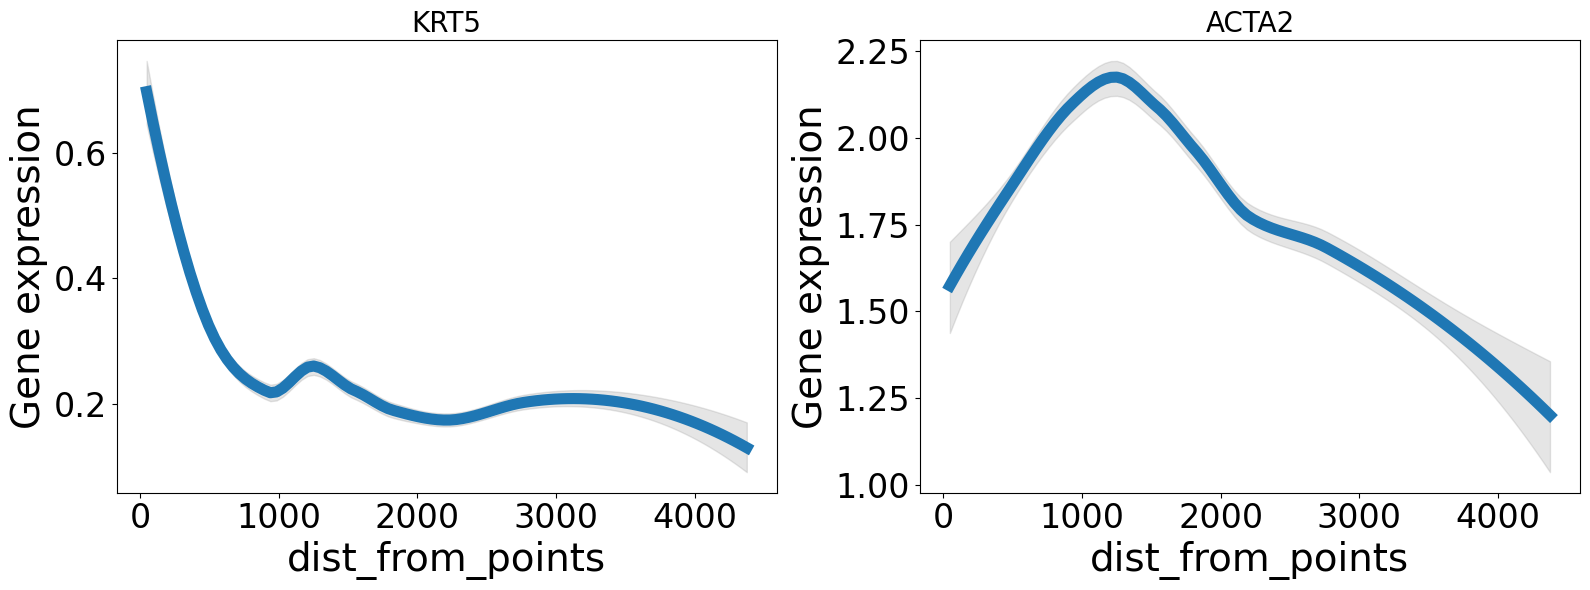

In [50]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=["KRT5", "ACTA2"],
                   x_category="dist_from_points", groupby=None, return_data=False,
                   stderr=True, nsteps=100, loess_bootstrap=True,
                   plot_legend=True
                   )

No valid labels found in axs[1].


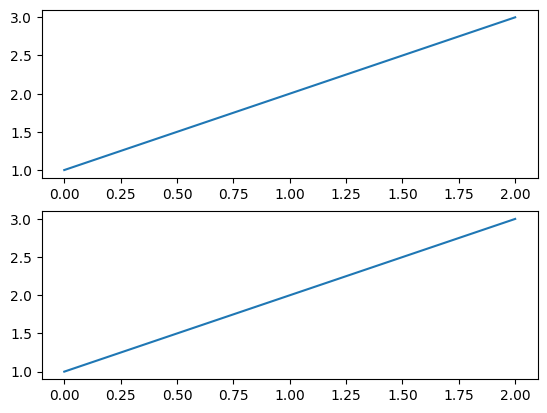

In [ ]:
import matplotlib.pyplot as plt

# Sample data
fig, axs = plt.subplots(2)

# Plotting some data
axs[0].plot([1, 2, 3], label='Line 1')
axs[1].plot([1, 2, 3], label='_Line 2')  # This label starts with an underscore

# Function to check if there are any valid labels
def has_valid_labels(ax):
    for artist in ax.get_legend_handles_labels()[0]:  # Get the handles (artists)
        if artist.get_label() and not artist.get_label().startswith('_'):
            return True
    return False

# Check before calling remove
for i in range(len(axs)):
    if has_valid_labels(axs[i]):
        axs[i].legend().remove()
    else:
        print(f"No valid labels found in axs[{i}].")

plt.show()

In [49]:
data

x    y_pred   std  conf_lower  conf_upper
key                                                              
ACTA2 None 0   494.611700  1.861635  True    1.819517    1.901300
           1   985.097950  2.118863  True    2.082049    2.151566
           2  1475.584199  2.112905  True    2.073190    2.136947
           3  1966.070448  1.885631  True    1.847892    1.921246
           4  2456.556698  1.728198  True    1.689438    1.776710
           5  2947.042947  1.641977  True    1.601819    1.696712
           6  3437.529196  1.515681  True    1.468952    1.588979
           7  3928.015445  1.363965  True    1.285653    1.487134

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


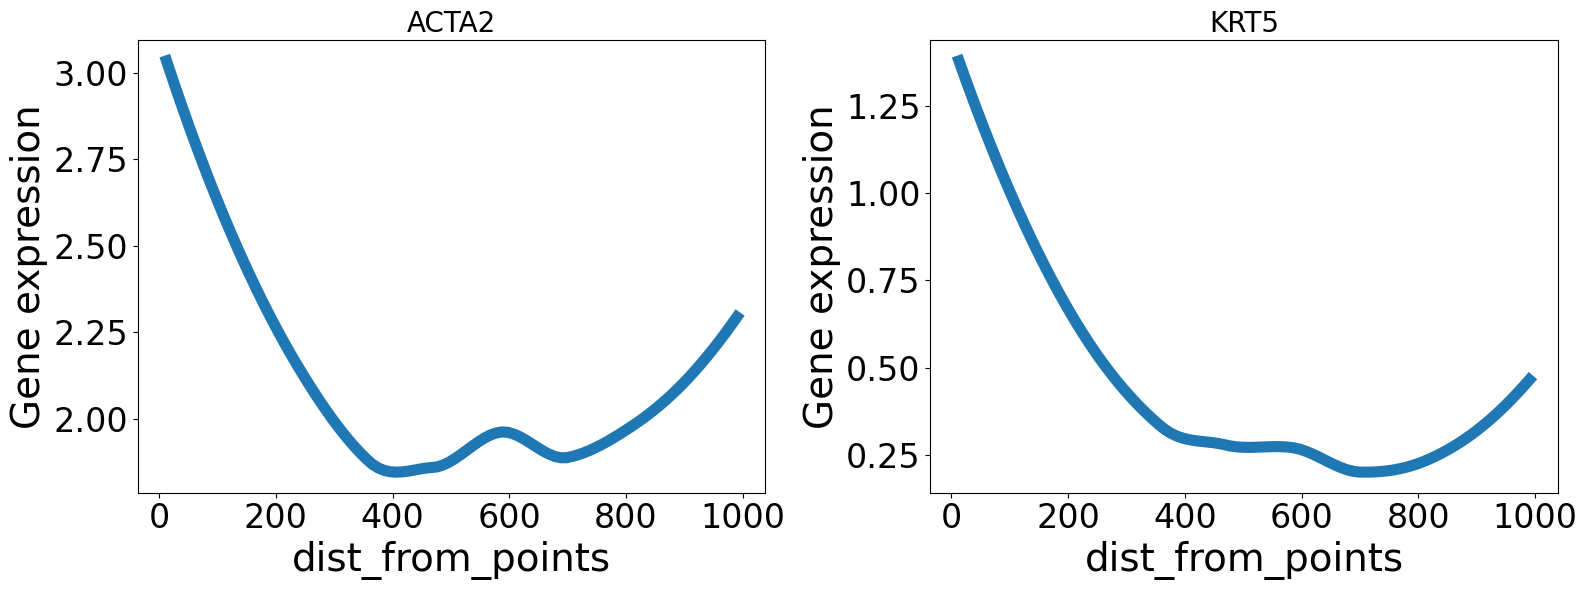

In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=["ACTA2", "KRT5"],
                   x_category="dist_from_points", groupby=None, return_data=False,
                   stderr=False, nsteps=100, plot_legend=False, xmax=1000
                   )

In [36]:
bl.bootstrap_result

array([[1.56066473, 1.52033767, 1.5326344 , ..., 1.5237538 , 1.58397976,
        1.56334441],
       [1.59230714, 1.55838512, 1.55954329, ..., 1.56089742, 1.61602656,
        1.59867783],
       [1.623157  , 1.59527489, 1.58603516, ..., 1.59698331, 1.64709395,
        1.63296001],
       ...,
       [1.23890861, 1.25425699, 1.24713157, ..., 1.32136992, 1.43136931,
        1.31792914],
       [1.2186458 , 1.23696772, 1.23129802, ..., 1.31034416, 1.42423382,
        1.30683595],
       [1.19799211, 1.21938718, 1.21527957, ..., 1.2992614 , 1.41705735,
        1.29565395]])

In [31]:
bl.stderr

array([0.06005632, 0.05404562, 0.04844665, 0.04328789, 0.03860167,
       0.03442365, 0.03079092, 0.02773728, 0.025285  , 0.02343355,
       0.02215034, 0.02137099, 0.02098834, 0.02089352, 0.02099217,
       0.02120858, 0.02148512, 0.02177909, 0.02205911, 0.02230195,
       0.02246259, 0.0224211 , 0.02232163, 0.02233459, 0.02254578,
       0.02291496, 0.0232845 , 0.02342459, 0.02311429, 0.0225995 ,
       0.02223944, 0.02223787, 0.0225531 , 0.02292419, 0.02300482,
       0.0227158 , 0.02228154, 0.02191342, 0.02170796, 0.02162238,
       0.02150571, 0.02114752, 0.02063408, 0.02010855, 0.01968998,
       0.0194484 , 0.01938974, 0.01945986, 0.0195695 , 0.01962383,
       0.01965326, 0.01971665, 0.01984903, 0.02007321, 0.02039681,
       0.02081147, 0.02129423, 0.0218106 , 0.02231854, 0.02277247,
       0.02312699, 0.02334817, 0.023456  , 0.02350222, 0.02349371,
       0.02343784, 0.02334471, 0.02322731, 0.02310183, 0.02298783,
       0.0229083 , 0.02288956, 0.0229607 , 0.02315272, 0.02349

In [65]:
def _single_bootstrap_loess(x, y, newdata, sample_frac=0.5):

    # subsample data
    samples = np.random.choice(len(x), int(len(x)*sample_frac), replace=True)
    y_s = y[samples]
    x_s = x[samples]

    # fit on subsampled data and predict for new data using LOESS
    ls = loess(x_s, y_s)
    pred = ls.predict(newdata)
    return pred.values

def calc_loess_stderror_by_bootstrap(x, y, newdata, sample_frac=0.5, K=100, **kwargs):
    '''
    Interesting input on topic from:
        - https://acclab.github.io/bootstrap-confidence-intervals.html
        - https://stackoverflow.com/questions/28242593/correct-way-to-obtain-confidence-interval-with-scipy
    '''
    # calculate confidence interval using bootstrapping approach
    bootstrap_result = np.stack([_single_bootstrap_loess(x, y, newdata, sample_frac=sample_frac, **kwargs) for k in range(K)]).T

    # calc mean and stderr of smooths
    stderr = np.nanstd(bootstrap_result, axis=1, ddof=0) # OR std

    return bootstrap_result, stderr

In [66]:
newdata = xs_pred
sample_frac = 0.5

# subsample data
samples = np.random.choice(len(x), int(len(x)*sample_frac), replace=True)
y_s = y[samples]
x_s = x[samples]

# fit on subsampled data and predict for new data using LOESS
ls = loess(x_s, y_s)
ls.fit()

In [67]:
newdata[:10]

array([ 48.71511017,  93.30476919, 137.89442822, 182.48408724,
       227.07374627, 271.6634053 , 316.25306432, 360.84272335,
       405.43238237, 450.0220414 ])

In [68]:
pred = ls.predict(xs_pred)

In [85]:
bootstrap_result, stderr = calc_loess_stderror_by_bootstrap(x=x, y=y, newdata=xs_pred, sample_frac=0.5, K=20)

In [86]:
df = pd.DataFrame(bootstrap_result, index=xs_pred)

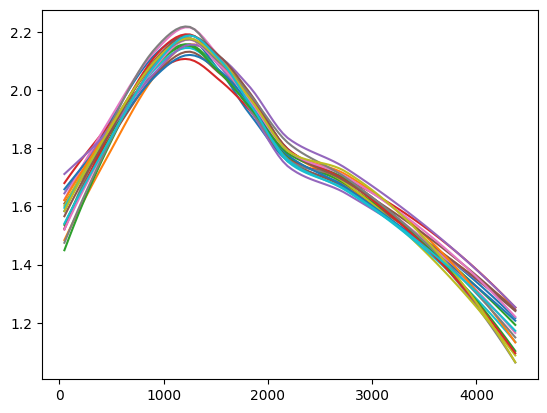

In [87]:
df.plot(kind="line", legend=False)
plt.show()

In [88]:
stderr

array([0.06845695, 0.06228753, 0.05650716, 0.05113681, 0.04620093,
       0.04172756, 0.03774772, 0.03429347, 0.03139389, 0.02906854,
       0.02732076, 0.02610999, 0.02536319, 0.02500146, 0.02493988,
       0.02509534, 0.02539227, 0.02576566, 0.0261616 , 0.02653653,
       0.02684704, 0.02709646, 0.02730686, 0.02750009, 0.0276758 ,
       0.02779855, 0.02779839, 0.02758109, 0.02682946, 0.02557861,
       0.02426564, 0.02324866, 0.0227022 , 0.02256469, 0.02253016,
       0.02228026, 0.02209139, 0.02217273, 0.0225478 , 0.02305418,
       0.02342499, 0.02353591, 0.02349834, 0.02338629, 0.02326282,
       0.02316508, 0.02309748, 0.02303468, 0.0229347 , 0.0227391 ,
       0.02245382, 0.02214052, 0.021834  , 0.02156528, 0.02135839,
       0.02122778, 0.02117666, 0.02119677, 0.02126976, 0.02136984,
       0.02146745, 0.02152458, 0.02156194, 0.02157617, 0.02156593,
       0.02153409, 0.02148503, 0.02142471, 0.0213607 , 0.02130226,
       0.02126031, 0.02124747, 0.02127786, 0.02136694, 0.02153

In [ ]:
ls.predict(x_s[:100])

In [18]:
x_s[:10]

array([1410.78397581,  177.95722952, 2297.80543826, 1257.50657933,
        377.56192491, 1339.67836252,  766.88789134, 2817.3637076 ,
       1677.34212741, 2963.61803577])

In [17]:
x_s.shape

(83890,)

In [40]:
ls.predict(x_s)

: 

In [ ]:

pred = ls.predict(newdata, stderror=False)

In [38]:
pred.values

array([1.57421127, 1.60581467, 1.63656586, 1.66654583, 1.69583558,
       1.72451611, 1.7526684 , 1.78037346, 1.80771227, 1.83476585,
       1.8616352 , 1.88870817, 1.91588475, 1.94287087, 1.96937247,
       1.99509549, 2.01974585, 2.04302949, 2.06465235, 2.08432037,
       2.10197492, 2.11886321, 2.13467716, 2.14876595, 2.16047879,
       2.16916485, 2.17417333, 2.17485342, 2.17008476, 2.16007845,
       2.1462615 , 2.13006113, 2.11290458, 2.09621908, 2.08087546,
       2.06327162, 2.04323531, 2.02169849, 1.99959311, 1.97785115,
       1.95726402, 1.93516551, 1.91095698, 1.88563059, 1.86017851,
       1.83559289, 1.81286591, 1.79298972, 1.77695648, 1.76524945,
       1.75558378, 1.74731477, 1.74017343, 1.73389078, 1.7281978 ,
       1.72282551, 1.71750492, 1.71196702, 1.70594283, 1.69916335,
       1.69135959, 1.68226699, 1.6724582 , 1.66247525, 1.65231558,
       1.64197662, 1.6314558 , 1.62075055, 1.60985832, 1.59877653,
       1.58750262, 1.57603401, 1.56436816, 1.55250248, 1.54043

In [36]:
newdata

array([  48.71511017,   93.30476919,  137.89442822,  182.48408724,
        227.07374627,  271.6634053 ,  316.25306432,  360.84272335,
        405.43238237,  450.0220414 ,  494.61170042,  539.20135945,
        583.79101848,  628.3806775 ,  672.97033653,  717.55999555,
        762.14965458,  806.7393136 ,  851.32897263,  895.91863166,
        940.50829068,  985.09794971, 1029.68760873, 1074.27726776,
       1118.86692678, 1163.45658581, 1208.04624483, 1252.63590386,
       1297.22556289, 1341.81522191, 1386.40488094, 1430.99453996,
       1475.58419899, 1520.17385801, 1564.76351704, 1609.35317607,
       1653.94283509, 1698.53249412, 1743.12215314, 1787.71181217,
       1832.30147119, 1876.89113022, 1921.48078925, 1966.07044827,
       2010.6601073 , 2055.24976632, 2099.83942535, 2144.42908437,
       2189.0187434 , 2233.60840242, 2278.19806145, 2322.78772048,
       2367.3773795 , 2411.96703853, 2456.55669755, 2501.14635658,
       2545.7360156 , 2590.32567463, 2634.91533366, 2679.50499

In [30]:
y_s

array([9., 2., 2., ..., 0., 8., 1.], dtype=float32)

In [33]:
y.shape

(167780,)

In [35]:
x_s.shape

(83890,)

In [26]:
ls.predict

In [1]:
ls.


SyntaxError: invalid syntax (879560176.py, line 1)

In [ ]:
calc_loess_stderror_by_bootstrap

In [17]:
ls.output_summary()

'Output Summary\n--------------\nNumber of Observations         : 167780\nFit flag                       : 1\nEquivalent Number of Parameters: 4.1\nResidual Standard Error        : 3.4368'

In [18]:
ls.input_summary()

'Model parameters\n----------------\nFamily          : gaussian\nSpan            : 0.75\nDegree          : 2\nNormalized      : True\nParametric      : [False]\nDrop_square     : [False]\n\nControl\n-------\nSurface type     : interpolate\nStatistics       : approximate\nTrace estimation : approximate\nCell size        : 0.2\nNb iterations    : 4'

In [21]:
y

array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)

In [19]:
y.T[0]

array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)

In [19]:
xd.path

WindowsPath('../demo_dataset/demo_insitupy_project')

In [20]:
xd.save()

Updating project in c:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
	Updating cells...
Saved.
Reloading following modalities: cells,images
Loading cells...
	No alternative cells found...
Loading images...


In [18]:
from insitupy.plotting.expression_along_axis import expr_along_obs_val

In [20]:
data = expr_along_obs_val(adata=xd.cells.matrix,
                   keys="ACTA2",
                   x_category="dist_from_points", groupby=None, return_data=True,
                   stderr=False, nsteps=10
                   )

In [21]:
data

x    y_pred    std
key                                       
ACTA2 None 0   354.693428  2.084774  False
           1   706.606128  1.922362  False
           2  1058.518828  1.881677  False
           3  1410.431528  1.866302  False
           4  1762.344228  2.026653  False
           5  2114.256927  1.849244  False
           6  2466.169627  1.562058  False
           7  2818.082327  1.168777  False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


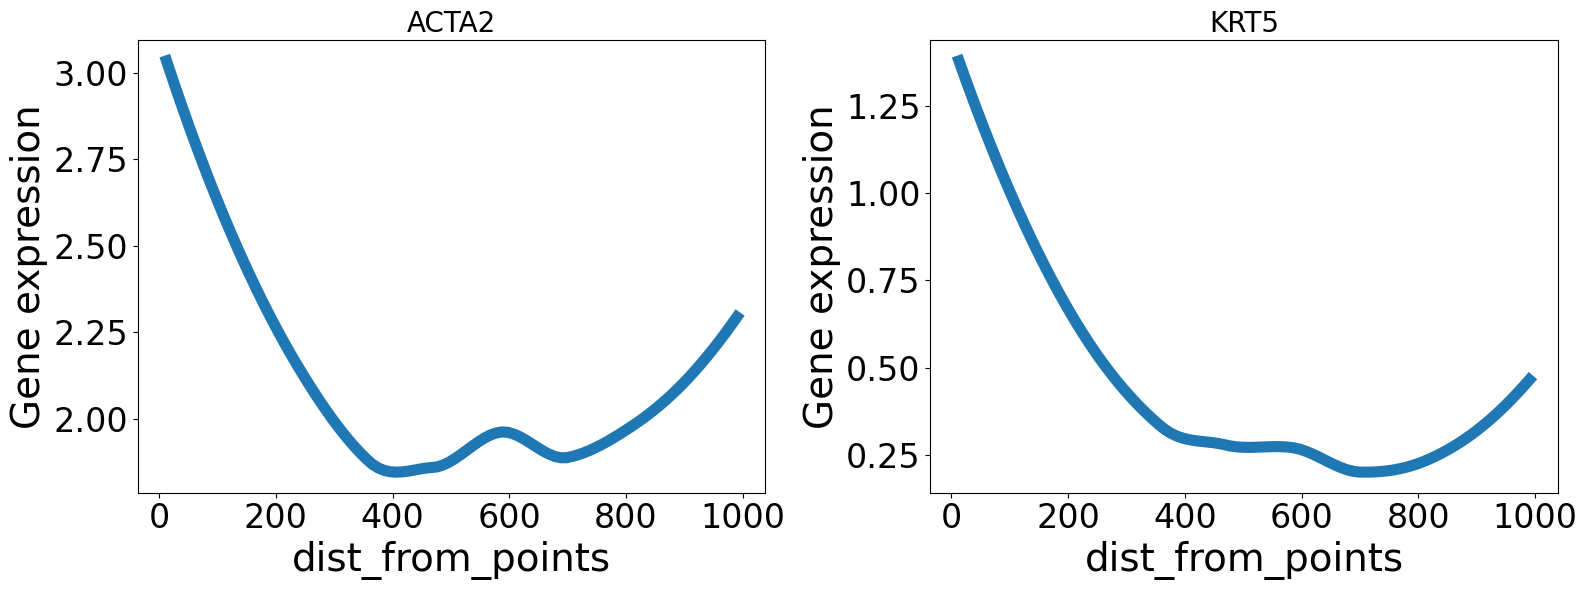

In [22]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=["ACTA2", "KRT5"],
                   x_category="dist_from_points", groupby=None, return_data=False,
                   stderr=False, nsteps=100, plot_legend=False, xmax=1000
                   )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


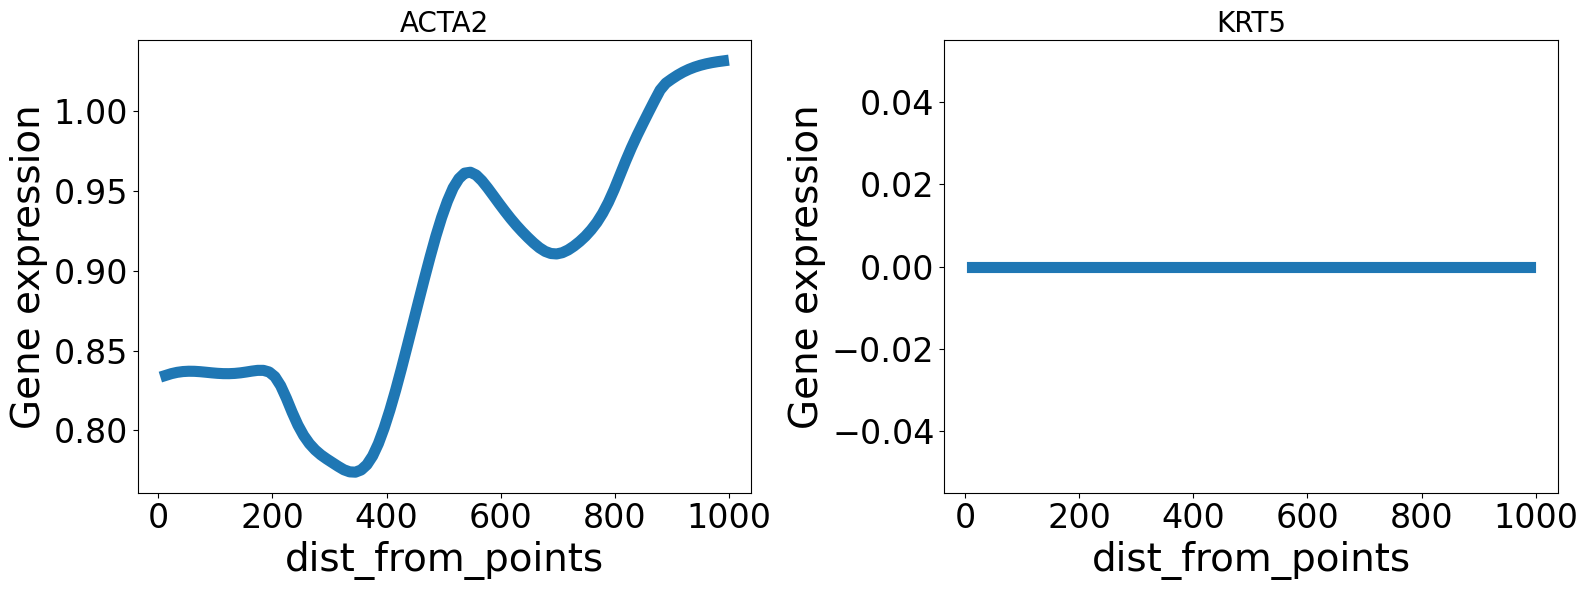

In [23]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=["ACTA2", "KRT5"], x_category="dist_from_points",
                   groupby=None, return_data=False,
                   method="lowess", stderr=False,
                   nsteps=100, plot_legend=False, xmax=1000
                   )

## Problems

1. `loess` makes the kernel crash when calculating the stderr
2. `lowess` custom function takes extremely low when calculating the stderr and when skipping stderr also takes very long plus produces weird results.

## Possible solution
1. use `loess` with custom bootstrapping as done in the custom `lowess` function. Should work definitely and not take too long since the `loess` prediction seems to be very fast.

In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=["ACTA2", "KRT5"], x_category="dist_from_points",
                   groupby=None, return_data=False,
                   method="lowess", stderr=True,
                   nsteps=100, plot_legend=False, xmax=1000
                   )

KeyboardInterrupt: 

Exception ignored in: 'statsmodels.nonparametric._smoothers_lowess.calculate_weights'
Traceback (most recent call last):
  File "c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\numpy\core\fromnumeric.py", line 2172, in _sum_dispatcher
    def _sum_dispatcher(a, axis=None, dtype=None, out=None, keepdims=None,
KeyboardInterrupt: 


<Axes: xlabel='x'>

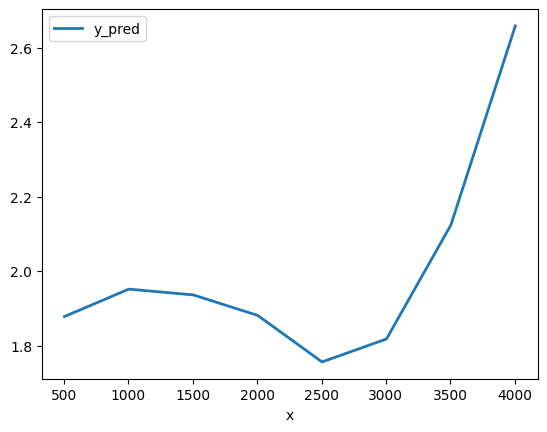

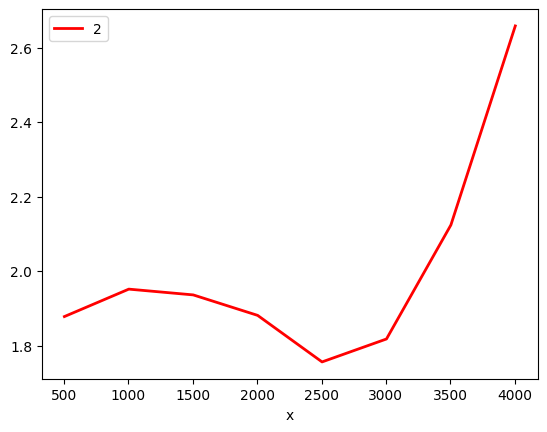

In [41]:
data.plot(kind="line", x="x", y="y_pred", label=None, color=None, linewidth=2)
data.plot(kind="line", x="x", y="y_pred", label="2", color="red", linewidth=2)

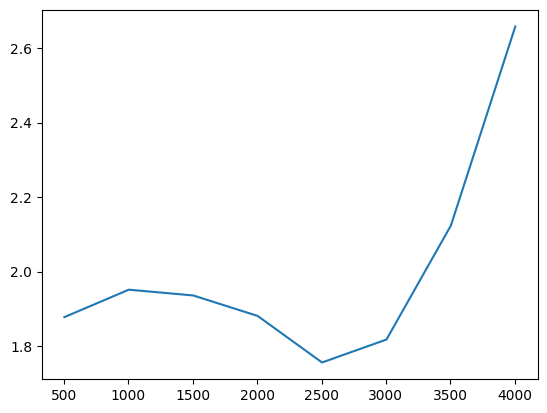

In [32]:
plt.plot(data["x"], data["y_pred"])

In [30]:
data.columns

Index(['x', 'y_pred', 'std', 'conf_lower', 'conf_upper'], dtype='object')

In [23]:
data

x    y_pred    std  conf_lower  conf_upper
key                                                               
ACTA2 None 0   504.257656  1.877883  False         NaN         NaN
           1  1004.245360  1.951516  False         NaN         NaN
           2  1504.233064  1.936031  False         NaN         NaN
           3  2004.220768  1.881070  False         NaN         NaN
           4  2504.208473  1.756132  False         NaN         NaN
           5  3004.196177  1.817721  False         NaN         NaN
           6  3504.183881  2.123669  False         NaN         NaN
           7  4004.171585  2.658033  False         NaN         NaN

In [27]:
ls, xs_pred = data

In [30]:
pred =  ls.predict(xs_pred, stderror=False)

: 

In [29]:
pred.stderr

ValueError: Standard error was not computed.Use 'stderror=True' when predicting.

In [24]:
data.stderr

ValueError: Standard error was not computed.Use 'stderror=True' when predicting.

In [23]:
data

x    y_pred    std  conf_lower  conf_upper
key                                                               
ACTA2 None 0   479.806029  2.100595  False         NaN         NaN
           1   958.483608  1.943201  False         NaN         NaN
           2  1437.161187  1.921318  False         NaN         NaN
           3  1915.838766  1.826385  False         NaN         NaN
           4  2394.516345  1.634902  False         NaN         NaN
           5  2873.193924  1.797144  False         NaN         NaN
           6  3351.871503  2.273278  False         NaN         NaN
           7  3830.549082  3.041486  False         NaN         NaN

In [33]:
xs

NameError: name 'xs' is not defined

ValueError: setting an array element with a sequence.

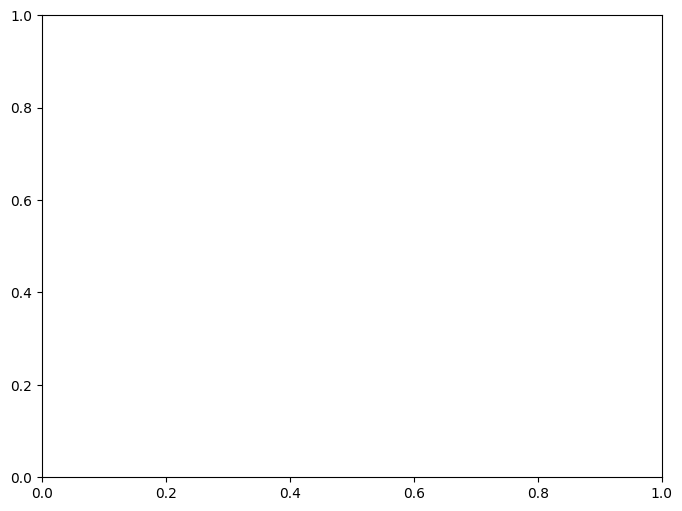

In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys="ACTA2",
                   x_category="dist_from_points", groupby=None
                   )

ValueError: setting an array element with a sequence.

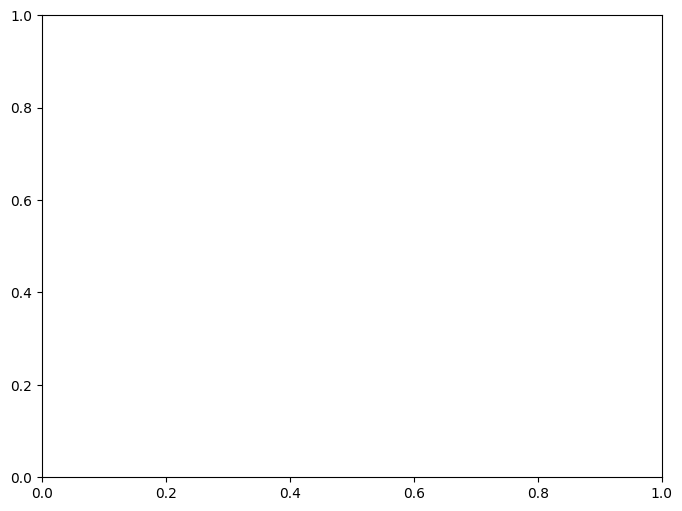

In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys="ACTA2",
                   x_category="dist_from_points", groupby=None
                   )

In [ ]:
a

In [19]:
dists.shape

(8, 167780)

In [13]:
points

<GeometryArray>
[<POINT (1910.078 2939.854)>, <POINT (2054.715 2852.311)>,
 <POINT (1872.015 2585.873)>, <POINT (1970.978 3210.098)>,
 <POINT (2225.996 3164.423)>,  <POINT (2069.94 3377.573)>,
  <POINT (2770.289 2974.11)>, <POINT (5278.293 1273.736)>]
Length: 8, dtype: geometry

In [12]:
dist.min()

10.316043603539608

In [91]:
dist

array([2840.97583443, 2847.16676686, 2835.26350056, ..., 5964.1267676 ,
       5974.66129396, 5983.51357957])

In [92]:
from shapely import LineString

In [93]:
ll.data[0]

array([[ 7264.325411  , 28308.07095047],
       [ 7743.80240649, 27436.29459505],
       [ 9182.23339293, 26491.87021001],
       [10577.0755616 , 24922.67277026],
       [11812.09206511, 23992.77799114],
       [13250.52305156, 23760.30429636]])

In [94]:
line_coords_xy = np.flip(ll.data[0], axis=1) * pixel_size

In [95]:
line = LineString(line_coords_xy)

In [96]:
cells.distance(line)

array([4779.33797023, 4797.11646734, 4775.46252531, ..., 3341.75590766,
       3353.85023477, 3358.49688704])

In [97]:
xd.cells.matrix.obs["line"] = cells.distance(line)
xd.cells.matrix.obs["line2"] = cells.distance(line)**2

In [82]:
xd.show()

In [99]:
adata = xd.cells.matrix

In [100]:
adata

AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2', 'line', 'line2'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
    varm: 'binned_expression'

In [102]:
adata.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [4., 1., 5., ..., 0., 0., 3.],
       [1., 0., 0., ..., 0., 0., 0.],
       [4., 1., 3., ..., 0., 0., 0.]], dtype=float32)

In [103]:
adata.obs

,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,annotation-demo,annotation-demo2,line,line2
1,28,1,0,29,58.387031,26.642188,NaN,NaN,4779.337970,2.284207e+07
2,94,0,0,94,197.016719,42.130781,NaN,NaN,4797.116467,2.301233e+07
3,9,0,0,9,16.256250,12.688906,NaN,NaN,4775.462525,2.280504e+07
4,11,0,0,11,42.311406,10.069844,NaN,NaN,4796.173524,2.300328e+07
5,48,0,0,48,107.652500,37.479688,NaN,NaN,4781.829921,2.286590e+07
...,...,...,...,...,...,...,...,...,...,...
167776,229,1,0,230,220.452813,60.599688,NaN,NaN,3328.190758,1.107685e+07
167777,79,0,0,79,37.389375,25.242344,NaN,NaN,3346.342668,1.119801e+07
167778,397,0,0,397,287.058281,86.700000,NaN,NaN,3341.755908,1.116733e+07
167779,117,0,0,117,235.354375,25.197188,NaN,NaN,3353.850235,1.124831e+07


In [104]:
adata.var

,gene_ids,feature_types,genome
ABCC11,ENSG00000121270,Gene Expression,Unknown
ACTA2,ENSG00000107796,Gene Expression,Unknown
ACTG2,ENSG00000163017,Gene Expression,Unknown
ADAM9,ENSG00000168615,Gene Expression,Unknown
ADGRE5,ENSG00000123146,Gene Expression,Unknown
...,...,...,...
VWF,ENSG00000110799,Gene Expression,Unknown
WARS,ENSG00000140105,Gene Expression,Unknown
ZEB1,ENSG00000148516,Gene Expression,Unknown
ZEB2,ENSG00000169554,Gene Expression,Unknown


In [44]:
xd.store_annotations()

Added 1 new annotations to key 'test'


In [46]:
xd.annotations.test

,objectType,geometry,name,color,origin
id,,,,,
5af017cc-02a8-4644-8687-7f07f4591693,annotation,"POLYGON ((6021.63193 1559.75951, 5801.00825 16...",blubb,"[255, 0, 0]",manual


In [47]:
xd.show()

In [42]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'annotation-demo', 'annotation-demo2'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear

In [62]:
l = xd.viewer.layers["Shapes"]
l2 = xd.viewer.layers["*blubb (test)"]
p = xd.viewer.layers["Points"]

In [56]:
l.shape_type

['path']

In [58]:
l2.shape_type

['polygon', 'polygon', 'path']

In [60]:
type(l2)

napari.layers.shapes.shapes.Shapes

In [61]:
type(l)

napari.layers.shapes.shapes.Shapes

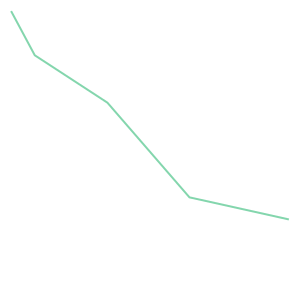

In [34]:
LineString(ll.data[0])

In [17]:
ll.data[0]

array([[ 7282.3753437 , 28338.57000552],
       [ 7817.66894886, 27339.35527589],
       [ 9459.23600467, 26268.76806558],
       [11314.92050255, 24127.59364495],
       [13563.15364421, 23627.98628013]])

In [22]:
ll.data[0][:, 0]

array([ 7282.3753437 ,  7817.66894886,  9459.23600467, 11314.92050255,
       13563.15364421])

In [24]:
s = gpd.points_from_xy(ll.data[0][:, 1], ll.data[0][:, 0])

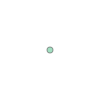

In [25]:
s[0]